In [53]:
%config InlineBackend.figure_format = 'retina'

In [54]:
import os
import re
import math
import pickle
import numpy as np
import squidpy as sq
import scanpy as sc
from collections import Counter
from glob import glob
import pandas as pd
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot
from matplotlib_venn import venn2,venn2_circles
from brokenaxes import brokenaxes
import seaborn as sns
from adjustText import adjust_text

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

In [55]:
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

In [56]:
def my_vmax(values): 
    return (np.percentile(values, 99)+np.max(values))/2

In [57]:
sns.set_style('ticks')

In [58]:
sc.set_figure_params(fontsize=20)

In [62]:
indir = '~/decidua/10xVisium/file/new'

In [63]:
normal_slices = ['A1_N59','B1_N59','C1_N56','D1_N56','C1_N65','D1_N65']
disease_slices = ['B1_P4','C1_P8B','D1_P9T','D1_P9B']

In [64]:
df_ls = []
space_dict = {}
for slide in normal_slices+disease_slices:
    path = os.path.join(indir,'SPACEL',f'{slide}.norm_log.h5ad')
    space_dict[slide] = sc.read_h5ad(path)
    df_ls.append(space_dict[slide].obs)

In [65]:
df_ls = []
for slide in normal_slices+disease_slices:
    path = os.path.join(indir,'cpdb',f'{slide}.co_express.nn.txt')
    corr_df = pd.read_csv(path, index_col=0, sep='\t')
    corr_df = corr_df['r'].to_frame()
    corr_df.columns = [slide]
    df_ls.append(corr_df)

In [66]:
raw_concat_corr_df = pd.concat(df_ls, axis=1)

In [67]:
tmp_cci_ls = []

for tmp in [normal_slices, disease_slices]:
    tmp_df = raw_concat_corr_df.loc[:,tmp]
    tmp_df = tmp_df[tmp_df.isna().sum(axis=1)<=2]
    tmp_df = tmp_df.fillna(0)
    tmp_cci_ls.extend(tmp_df[tmp_df.mean(axis=1)>0].index.tolist())

filter_ccis = list(set(tmp_cci_ls))
len(filter_ccis)

1186

In [68]:
filter_concat_corr_df = raw_concat_corr_df.loc[filter_ccis].fillna(0)

In [69]:
norm_cci_mean_r = filter_concat_corr_df.loc[:,normal_slices].mean(axis=1)
rpl_cci_mean_r = filter_concat_corr_df.loc[:,disease_slices].mean(axis=1)

In [70]:
tmp_pval_ls = []
tmp_state_ls = []

for cci in filter_concat_corr_df.index:
    norm_cci_mean = norm_cci_mean_r.loc[cci]
    rpl_cci_mean = rpl_cci_mean_r.loc[cci]
    pval = ranksums(filter_concat_corr_df.loc[cci, normal_slices], filter_concat_corr_df.loc[cci, disease_slices])[1]
    
    tmp_pval_ls.append(pval)
#     if norm_cci_mean > rpl_cci_mean and pval < 0.05:
#         tmp_state_ls.append('Ctrl')
#     elif rpl_cci_mean > norm_cci_mean and pval < 0.05:
#         tmp_state_ls.append('RPL')
    if (norm_cci_mean-rpl_cci_mean)>=0.1 and pval < 0.05:
        tmp_state_ls.append('Ctrl')
    elif (rpl_cci_mean-norm_cci_mean)>=0.1 and pval < 0.05:
        tmp_state_ls.append('RPL')
    else:
        tmp_state_ls.append('Other')

In [71]:
result_df = pd.DataFrame({
    'pval':tmp_pval_ls, 'state':tmp_state_ls
}, index=filter_concat_corr_df.index)

In [72]:
states = ['Other','Ctrl','RPL']
state_colors = ['#d8dcd6','#6299c5','#cc453b']
state_sizes = [5,20,20]

state_cci_dict = {}
for state in states:
    state_cci_dict[state] = result_df[result_df['state']==state].index.tolist()

In [73]:
norm_d1_ccis = list(np.loadtxt(indir+'/cpdb/Domain1_enriched_ccis.txt', dtype=str))
norm_d2_ccis = list(np.loadtxt(indir+'/cpdb/Domain2_enriched_ccis.txt', dtype=str))

In [74]:
states = ['Other','Ctrl','RPL']
state_colors = ['#d8dcd6','#6299c5','#cc453b']
state_sizes = [10,50,50]

state_color_dict = dict(zip(states, state_colors))
state_size_dict = dict(zip(states, state_sizes))

In [75]:
# domain LR pair count

In [76]:
cut_r = 0
cut_padj = 0.05

tmp_count_ls = []
tmp_state_ls = []
tmp_domain_ls = []
tmp_slide_ls = []

for slide in normal_slices:
    path = os.path.join(indir,'cpdb',f'{slide}.co_express.nn.txt')
    cci_coexpress_df = pd.read_csv(path, sep='\t', index_col=0)
    path = os.path.join(indir,'cpdb',slide,'Domain1_enriched_ccis.txt')
    domain1_cpdb_ccis = list(np.loadtxt(path, dtype=str))
    path = os.path.join(indir,'cpdb',slide,'Domain2_enriched_ccis.txt')
    domain2_cpdb_ccis = list(np.loadtxt(path, dtype=str))
    
    filter_cci_coexpress_df = cci_coexpress_df[(cci_coexpress_df['r']>=cut_r) & (cci_coexpress_df['padj']<cut_padj)]
    
#     tmp_count_ls.append(filter_cci_coexpress_df.shape[0])
#     tmp_state_ls.append('Ctrl')
    domain1_enriched_ccis = list(set(filter_cci_coexpress_df.index).intersection(set(domain1_cpdb_ccis)))
    domain2_enriched_ccis = list(set(filter_cci_coexpress_df.index).intersection(set(domain2_cpdb_ccis)))
    print(len(domain1_enriched_ccis), len(domain2_enriched_ccis))
    
    
    tmp_count_ls.extend([len(domain1_enriched_ccis), len(domain2_enriched_ccis)])
    tmp_state_ls.extend(['Ctrl','Ctrl'])
    tmp_domain_ls.extend(['D1','D2'])
    tmp_slide_ls.extend([slide]*2)
    
for slide in disease_slices:
    path = os.path.join(indir,'cpdb',f'{slide}.co_express.nn.txt')
    cci_coexpress_df = pd.read_csv(path, sep='\t', index_col=0)
    path = os.path.join(indir,'cpdb',slide,'Domain1_enriched_ccis.txt')
    domain1_cpdb_ccis = list(np.loadtxt(path, dtype=str))
    path = os.path.join(indir,'cpdb',slide,'Domain2_enriched_ccis.txt')
    domain2_cpdb_ccis = list(np.loadtxt(path, dtype=str))
    
    filter_cci_coexpress_df = cci_coexpress_df[(cci_coexpress_df['r']>=cut_r) & (cci_coexpress_df['padj']<cut_padj)]
    
#     tmp_count_ls.append(filter_cci_coexpress_df.shape[0])
#     tmp_state_ls.append('RPL')
    domain1_enriched_ccis = list(set(filter_cci_coexpress_df.index).intersection(set(domain1_cpdb_ccis)))
    domain2_enriched_ccis = list(set(filter_cci_coexpress_df.index).intersection(set(domain2_cpdb_ccis)))
    print(len(domain1_enriched_ccis), len(domain2_enriched_ccis))
    
    tmp_count_ls.extend([len(domain1_enriched_ccis), len(domain2_enriched_ccis)])
    tmp_state_ls.extend(['RPL','RPL'])
    tmp_domain_ls.extend(['D1','D2'])
    tmp_slide_ls.extend([slide]*2)

122 34
133 36
154 20
150 33
125 29
148 34
27 15
56 38
13 5
45 14


In [77]:
# result_df = pd.DataFrame({'count':tmp_count_ls, 'state':tmp_state_ls})
result_df = pd.DataFrame({'count':tmp_count_ls, 'state':tmp_state_ls, 'domain':tmp_domain_ls, 'slide':tmp_slide_ls})

In [78]:
slide_cci_count_df = result_df.groupby('slide').sum()

In [79]:
slide_cci_count_df['state'] = slide_cci_count_df.index.map(lambda x:'P' if re.search('P',x) else 'N')

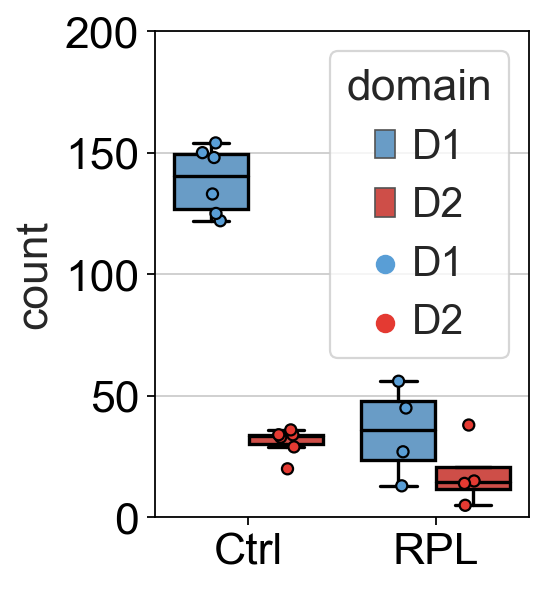

In [80]:
fig = plt.figure(figsize=(3,4))
ax21 = plt.subplot(111)
g = sns.boxplot(x='state', y='count', hue='domain', data=result_df, ax=ax21, fliersize=0, 
                palette=['#599ed6','#e43a32'], **PROPS)
sns.stripplot(x='state', y='count', hue='domain', data=result_df, linewidth=1, ax=ax21, 
              palette=['#599ed6','#e43a32'], size=5, edgecolor='black', dodge=True)
_ = ax21.set_xlabel('')
_ = ax21.set_ylim([0,200])

In [81]:
for domain in ['D1','D2']:
    sel_result_df = result_df[result_df['domain']==domain]
    pval = ranksums(sel_result_df[sel_result_df['state']=='Ctrl']['count'], 
                    sel_result_df[sel_result_df['state']=='RPL']['count'])[1]
    print(domain, pval)

D1 0.010515245935858907
D2 0.2008251226951454


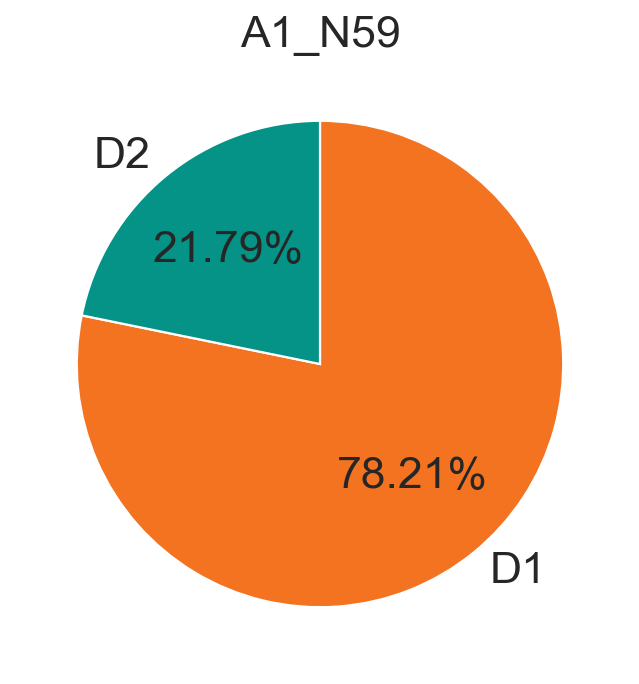

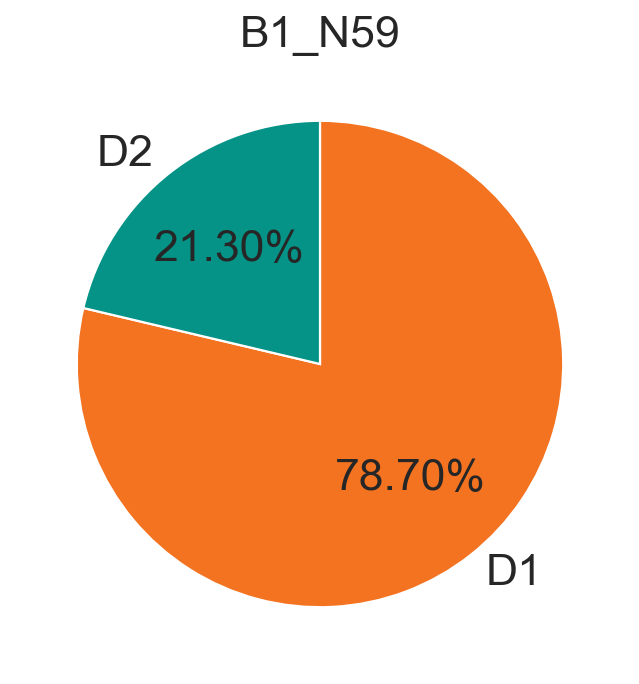

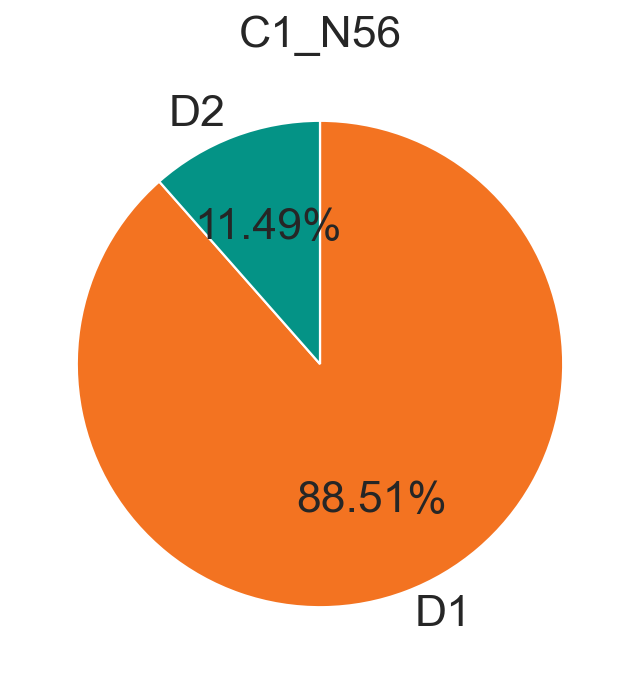

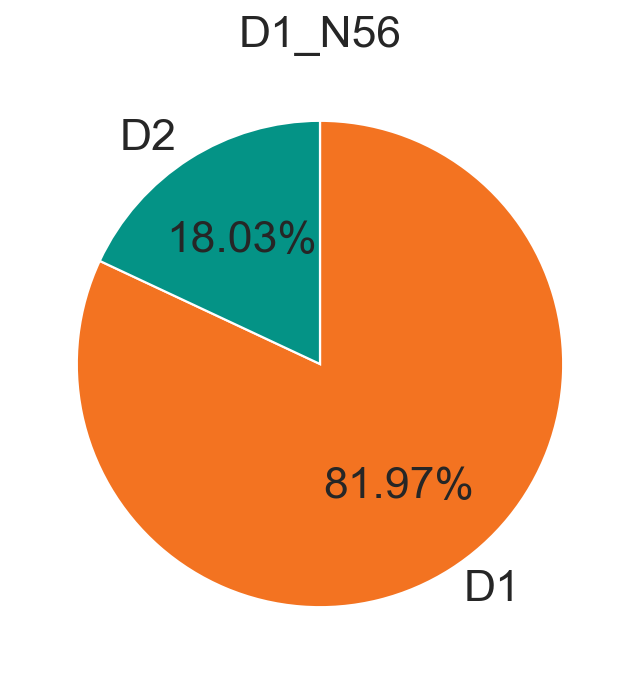

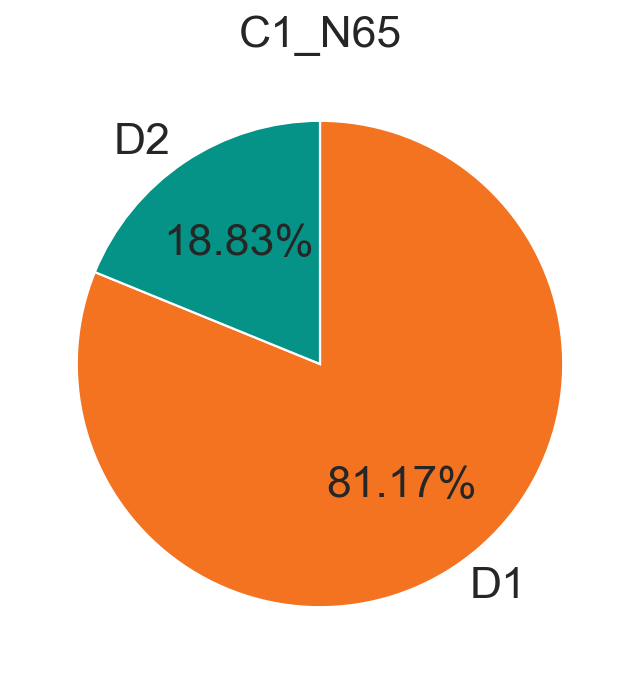

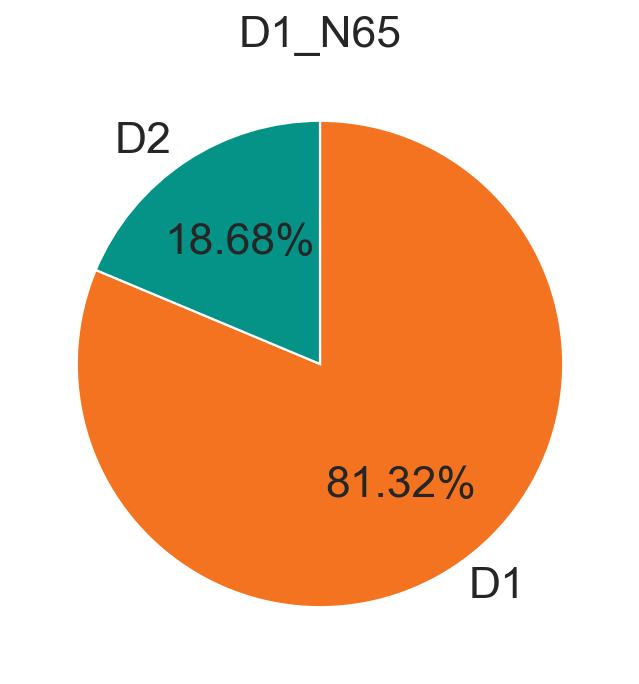

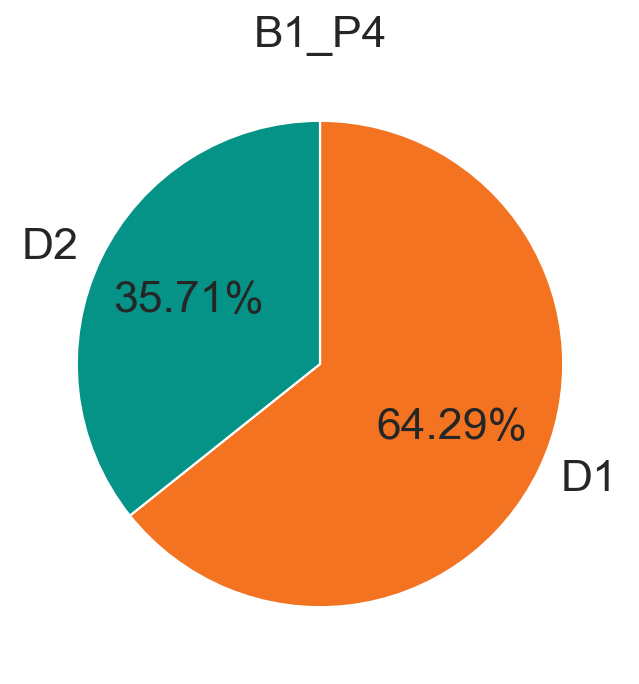

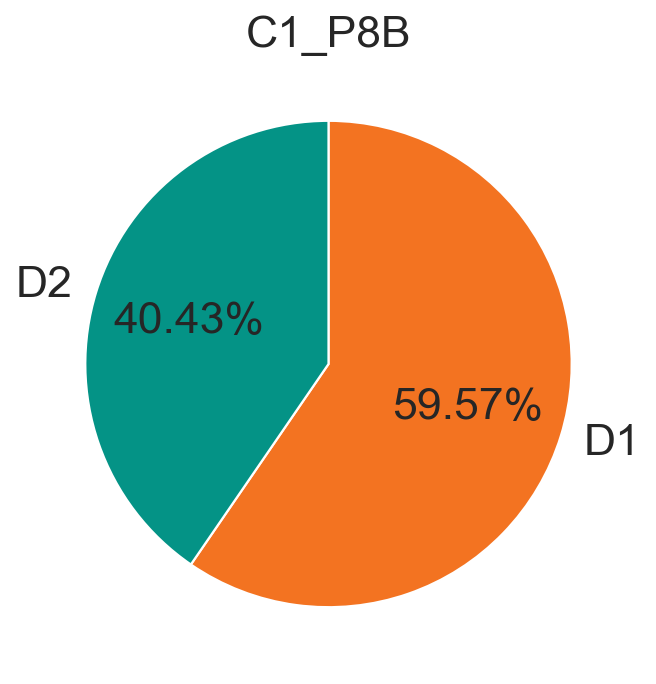

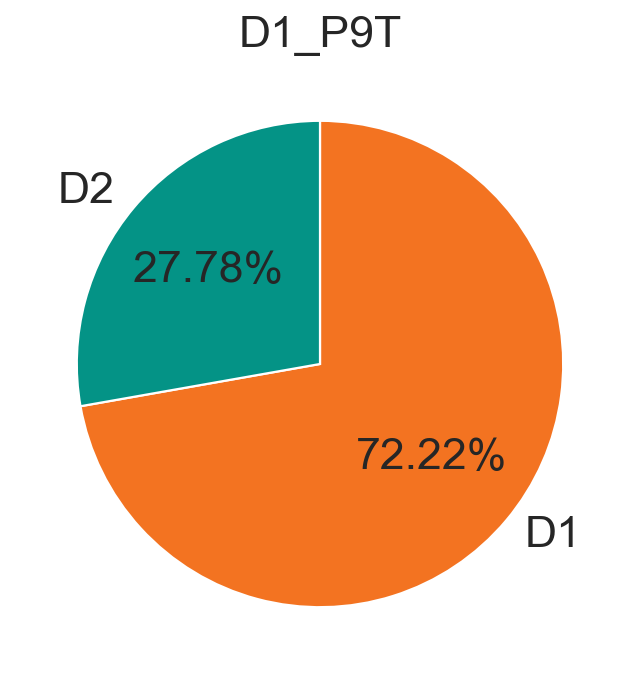

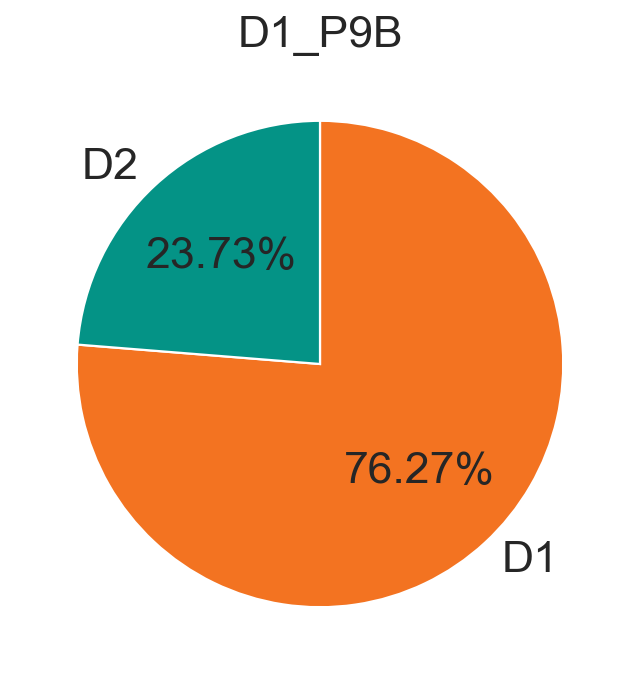

In [82]:
for slide in normal_slices+disease_slices:
    sel_df = result_df[result_df['slide']==slide]
    plt.figure(figsize=(5,5))
    plt.pie(sel_df['count'], labels=['D1','D2'], colors=['#f37321','#049386'], 
            counterclock=False, startangle=90, autopct='%.2f%%')
    _ = plt.title(slide)

In [83]:
cut_r = 0
cut_padj = 0.05

tmp_domain1_ccis = []
tmp_domain2_ccis = []

tmp_count_ls = []
tmp_domain_ls = []

for slide in disease_slices:
    path = os.path.join(indir,'cpdb',f'{slide}.co_express.nn.txt')
    cci_coexpress_df = pd.read_csv(path, sep='\t', index_col=0)
    path = os.path.join(indir,'cpdb',slide,'Domain1_enriched_ccis.txt')
    domain1_cpdb_ccis = list(np.loadtxt(path, dtype=str))
    path = os.path.join(indir,'cpdb',slide,'Domain2_enriched_ccis.txt')
    domain2_cpdb_ccis = list(np.loadtxt(path, dtype=str))
    
    filter_cci_coexpress_df = cci_coexpress_df[(cci_coexpress_df['r']>=cut_r) & (cci_coexpress_df['padj']<cut_padj)]
    domain1_enriched_ccis = list(set(filter_cci_coexpress_df.index).intersection(set(domain1_cpdb_ccis)))
    domain2_enriched_ccis = list(set(filter_cci_coexpress_df.index).intersection(set(domain2_cpdb_ccis)))
    print(len(domain1_enriched_ccis), len(domain2_enriched_ccis))
    
    tmp_domain1_ccis.extend(domain1_enriched_ccis)
    tmp_domain2_ccis.extend(domain2_enriched_ccis)
    
    tmp_count_ls.extend([len(domain1_enriched_ccis),len(domain2_enriched_ccis)])
    tmp_domain_ls.extend(['Domain1','Domain2'])

27 15
56 38
13 5
45 14


In [84]:
result_count_df = pd.DataFrame({
    'count':tmp_count_ls, 'domain':tmp_domain_ls
})

In [85]:
final_domain1_ccis = []
final_domain2_ccis = []

cci_count_dict = Counter(tmp_domain1_ccis)
for cci, count in cci_count_dict.items():
    if count >= 2:
        final_domain1_ccis.append(cci)
cci_count_dict = Counter(tmp_domain2_ccis)
for cci, count in cci_count_dict.items():
    if count >= 2:
        final_domain2_ccis.append(cci)
        
print(len(final_domain1_ccis), len(final_domain2_ccis))

36 11


In [86]:
path = os.path.join(indir,'cpdb/Domain1_enriched_ccis.txt')
norm_d1_ccis = list(np.loadtxt(path, dtype=str))
path = os.path.join(indir,'cpdb/Domain2_enriched_ccis.txt')
norm_d2_ccis = list(np.loadtxt(path, dtype=str))

path = os.path.join(indir,'cpdb/RPL.Domain1_enriched_ccis.txt')
rpl_d1_ccis = list(np.loadtxt(path, dtype=str))
path = os.path.join(indir,'cpdb/RPL.Domain2_enriched_ccis.txt')
rpl_d2_ccis = list(np.loadtxt(path, dtype=str))

norm_all_ccis = norm_d1_ccis+norm_d2_ccis
rpl_all_ccis = rpl_d1_ccis+rpl_d2_ccis

In [87]:
slide_cci_dict = {}
for slide in normal_slices+disease_slices:
    path = os.path.join(indir,'cpdb',f'{slide}.co_express.nn.txt')
    cci_coexpress_df = pd.read_csv(path, sep='\t', index_col=0)
    path = os.path.join(indir,'cpdb',slide,'Domain1_enriched_ccis.txt')
    domain1_cpdb_ccis = list(np.loadtxt(path, dtype=str))
    path = os.path.join(indir,'cpdb',slide,'Domain2_enriched_ccis.txt')
    domain2_cpdb_ccis = list(np.loadtxt(path, dtype=str))
    
    filter_cci_coexpress_df = cci_coexpress_df[(cci_coexpress_df['r']>=cut_r) & (cci_coexpress_df['padj']<cut_padj)]
    
    slide_cci_dict[slide] = filter_cci_coexpress_df.index.tolist()

In [88]:
path = os.path.join(indir,'SPACEL/Normal_crop_coord.pkl')
with open(path, 'rb') as handle:
    coord_dict = pickle.load(handle)
    
path = os.path.join(indir,'SPACEL/RPL_crop_coord.pkl')
with open(path, 'rb') as handle:
    rpl_coord_dict = pickle.load(handle)
    
coord_dict.update(rpl_coord_dict)

In [89]:
norm_up_ccis = state_cci_dict['Ctrl']
rpl_up_ccis = state_cci_dict['RPL']

In [90]:
cellchat_info_df = pd.read_csv('/home/yuqiaoni/decidua/10xVisium/file/2Cluster/cellchat/interaction_input_CellChatDB.combined.csv', sep='\t', index_col=0)
all_cellchat_ccis = cellchat_info_df.index.tolist()

In [91]:
tmp_cci_ls = []
tmp_pathway_ls = []
tmp_ligand_ls = []
tmp_receptor_ls = []

for cci in norm_up_ccis:
    cci_r = cci.split('|')[1]+'_'+cci.split('|')[0]
    cci = cci.replace('|','_')
    if cci in all_cellchat_ccis:
        pathway = cellchat_info_df.loc[cci,'pathway_name']
        tmp_cci_ls.append(cci)
        tmp_pathway_ls.append(pathway)
        tmp_ligand_ls.append(cellchat_info_df.loc[cci,'ligand'])
        tmp_receptor_ls.append(cellchat_info_df.loc[cci,'receptor'])
    elif cci_r in all_cellchat_ccis:
        pathway = cellchat_info_df.loc[cci_r,'pathway_name']
        tmp_cci_ls.append(cci)
        tmp_pathway_ls.append(pathway)
        tmp_ligand_ls.append(cellchat_info_df.loc[cci_r,'ligand'])
        tmp_receptor_ls.append(cellchat_info_df.loc[cci_r,'receptor'])
    else:
        if re.match('COL', cci) and re.search('ITG', cci):
            pathway = 'COLLAGEN'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            tmp_ligand_ls.append(cci.split('_')[0])
            tmp_receptor_ls.append(cci.split('_')[1])
        elif re.search('LGALS', cci):
            pathway = 'GALECTIN'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            if re.match('LGALS', gene_a):
                tmp_ligand_ls.append(gene_a)
                tmp_receptor_ls.append(gene_b)
            else:
                tmp_ligand_ls.append(gene_b)
                tmp_receptor_ls.append(gene_a)
        elif re.search('FN1', cci):
            pathway = 'FN1'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('PTPRC', cci):
            pathway = 'CD45'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('THY1', cci):
            pathway = 'THY1'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('JAM', cci):
            pathway = 'JAM'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            if re.match('JAM', gene_a):
                tmp_ligand_ls.append(gene_a)
                tmp_receptor_ls.append(gene_b)
            else:
                tmp_ligand_ls.append(gene_b)
                tmp_receptor_ls.append(gene_a)
        elif re.search('HLA', cci) or re.search('KLR', cci):
            pathway = 'MHC-I'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            if re.match('HLA', gene_a):
                tmp_ligand_ls.append(gene_a)
                tmp_receptor_ls.append(gene_b)
            else:
                tmp_ligand_ls.append(gene_b)
                tmp_receptor_ls.append(gene_a)
        elif re.search('ICAM', cci):
            pathway = 'ICAM'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('LILRB', cci):
            pathway = 'MHC-I'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            if re.match('LILRB', gene_a):
                tmp_ligand_ls.append(gene_b)
                tmp_receptor_ls.append(gene_a)
            else:
                tmp_ligand_ls.append(gene_a)
                tmp_receptor_ls.append(gene_b)
        elif re.search('CSPG4', cci):
            pathway = 'CSPG4'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('WNT', cci):
            pathway = 'WNT'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('ITGA|ITGB', cci):
            pathway = 'COLLAGEN'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
#             print(cci)
        else:
            print(cci)

CD52_SIGLEC10
APOA1_TYROBP
DHCR24_RORC
TYROBP_CD44
CD47_TYROBP
ERBB3_BTC
PLAU_PLAUR
PYY_DPP4


In [92]:
norm_up_cci_meta_df = pd.DataFrame({'pathway':tmp_pathway_ls, 'ligand':tmp_ligand_ls, 'receptor':tmp_receptor_ls}, index=tmp_cci_ls)

In [93]:
norm_up_pathway_count_dict = Counter(norm_up_cci_meta_df['pathway'])

In [94]:
norm_up_cci_meta_df[norm_up_cci_meta_df['pathway']=='CSPG4']

,pathway,ligand,receptor
CSPG4_ITGB1,CSPG4,CSPG4,ITGB1


In [95]:
order_pathways = [x[0] for x in sorted(norm_up_pathway_count_dict.items(), key=lambda item: item[1], reverse=True)]

In [96]:
# order_pathways2 = ['COLLAGEN','GALECTIN','MHC-I',
#                    'THY1','WNT','FGF',
#                    'IL2','CSF','LAMININ','ncWNT','VEGF',
#                    'CD39','PRL','ANNEXIN','CCL','IL1','CD99']
order_pathways2 = ['COLLAGEN','GALECTIN','MHC-I',
                   'THY1','WNT','FGF',
                   'IL2','CSF','LAMININ','ncWNT','VEGF',
                   'CD39','PRL','ANNEXIN','CD99']

In [97]:
tmp_cci_ls = []
tmp_pathway_ls = []
tmp_ligand_ls = []
tmp_receptor_ls = []

for cci in rpl_up_ccis:
    cci_r = cci.split('|')[1]+'_'+cci.split('|')[0]
    cci = cci.replace('|','_')
    if cci in all_cellchat_ccis:
        pathway = cellchat_info_df.loc[cci,'pathway_name']
        tmp_cci_ls.append(cci)
        tmp_pathway_ls.append(pathway)
        tmp_ligand_ls.append(cellchat_info_df.loc[cci,'ligand'])
        tmp_receptor_ls.append(cellchat_info_df.loc[cci,'receptor'])
    elif cci_r in all_cellchat_ccis:
        pathway = cellchat_info_df.loc[cci_r,'pathway_name']
        tmp_cci_ls.append(cci)
        tmp_pathway_ls.append(pathway)
        tmp_ligand_ls.append(cellchat_info_df.loc[cci_r,'ligand'])
        tmp_receptor_ls.append(cellchat_info_df.loc[cci_r,'receptor'])
    else:
        if re.match('COL', cci) and re.search('ITG', cci):
            pathway = 'COLLAGEN'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            tmp_ligand_ls.append(cci.split('_')[0])
            tmp_receptor_ls.append(cci.split('_')[1])
        elif re.search('WNT', cci):
            pathway = 'WNT'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('ITGA|ITGB', cci):
            pathway = 'COLLAGEN'
            tmp_cci_ls.append(cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
            print(cci)
        else:
            print(cci)

F11R_ITGB2
RORB_ALDH1A1
RORB_ALDH1A3
EBI3_IL6ST
PLA2G2A_ITGA5


In [98]:
rpl_up_cci_meta_df = pd.DataFrame({'pathway':tmp_pathway_ls, 'ligand':tmp_ligand_ls, 'receptor':tmp_receptor_ls}, index=tmp_cci_ls)

In [99]:
rpl_up_pathway_count_dict = Counter(rpl_up_cci_meta_df['pathway'])

In [102]:
df_ls = []
for slide in normal_slices+disease_slices:
    path = os.path.join(indir,'cpdb',f'{slide}.co_express.nn.txt')
    corr_df = pd.read_csv(path, index_col=0, sep='\t')
    corr_df = corr_df['r'].to_frame()
    corr_df.columns = [slide]
    df_ls.append(corr_df)

In [103]:
raw_concat_corr_df = pd.concat(df_ls, axis=1)

In [104]:
tmp_cci_ls = []

for tmp in [normal_slices, disease_slices]:
    tmp_df = raw_concat_corr_df.loc[:,tmp]
    tmp_df = tmp_df[tmp_df.isna().sum(axis=1)<=2]
    tmp_df = tmp_df.fillna(0)
    tmp_cci_ls.extend(tmp_df[tmp_df.mean(axis=1)>0].index.tolist())

filter_ccis = list(set(tmp_cci_ls))
len(filter_ccis)

1186

In [105]:
filter_concat_corr_df = raw_concat_corr_df.loc[filter_ccis].fillna(0)

In [106]:
# norm_raw_ccis = filter_concat_corr_df[filter_concat_corr_df.loc[:,normal_slices].min(axis=1)>=0].index.tolist()
# rpl_raw_ccis = filter_concat_corr_df[filter_concat_corr_df.loc[:,disease_slices].min(axis=1)>=0].index.tolist()
norm_raw_ccis = filter_concat_corr_df[filter_concat_corr_df.loc[:,normal_slices].mean(axis=1)>=0].index.tolist()
rpl_raw_ccis = filter_concat_corr_df[filter_concat_corr_df.loc[:,disease_slices].mean(axis=1)>=0].index.tolist()

print(len(norm_raw_ccis), len(rpl_raw_ccis))

910 860


In [107]:
diff_d1_cci_df = pd.read_csv(indir+'/cpdb/Domain1_ccis.Ctrl_vs_RPL.from_seurat.csv', index_col=0)
diff_d2_cci_df = pd.read_csv(indir+'/cpdb/Domain2_ccis.Ctrl_vs_RPL.from_seurat.csv', index_col=0)

diff_d1_cci_df.index = [x.replace('.','|') for x in diff_d1_cci_df.index]
diff_d1_cci_df['gene'] = [x.replace('.','|') for x in diff_d1_cci_df['gene']]
diff_d2_cci_df.index = [x.replace('.','|') for x in diff_d2_cci_df.index]
diff_d2_cci_df['gene'] = [x.replace('.','|') for x in diff_d2_cci_df['gene']]

diff_d1_cci_df = diff_d1_cci_df[(diff_d1_cci_df['p_val']<1e-10) & (diff_d1_cci_df['avg_log2FC']>=0.1) & (diff_d1_cci_df['pct.1'] > diff_d1_cci_df['pct.2'])]
diff_d2_cci_df = diff_d2_cci_df[(diff_d2_cci_df['p_val']<1e-10) & (diff_d2_cci_df['avg_log2FC']>=0.1) & (diff_d1_cci_df['pct.1'] > diff_d1_cci_df['pct.2'])]
print(diff_d1_cci_df['cluster'].value_counts())
print(diff_d2_cci_df['cluster'].value_counts())

Ctrl    74
RPL     25
Name: cluster, dtype: int64
RPL     29
Ctrl    21
Name: cluster, dtype: int64


/tmp/ipykernel_145800/583849394.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diff_d2_cci_df = diff_d2_cci_df[(diff_d2_cci_df['p_val']<1e-10) & (diff_d2_cci_df['avg_log2FC']>=0.1) & (diff_d1_cci_df['pct.1'] > diff_d1_cci_df['pct.2'])]


In [108]:
d1_norm_up_ccis = list(set(diff_d1_cci_df[diff_d1_cci_df['cluster']=='Ctrl']['gene']).intersection(set(norm_raw_ccis)))
d2_norm_up_ccis = list(set(diff_d2_cci_df[diff_d2_cci_df['cluster']=='Ctrl']['gene']).intersection(set(norm_raw_ccis)))
d1_rpl_up_ccis = list(set(diff_d1_cci_df[diff_d1_cci_df['cluster']=='RPL']['gene']).intersection(set(rpl_raw_ccis)))
d2_rpl_up_ccis = list(set(diff_d2_cci_df[diff_d2_cci_df['cluster']=='RPL']['gene']).intersection(set(rpl_raw_ccis)))
print(len(d1_norm_up_ccis), len(d2_norm_up_ccis), len(d1_rpl_up_ccis), len(d2_rpl_up_ccis))

56 16 21 24


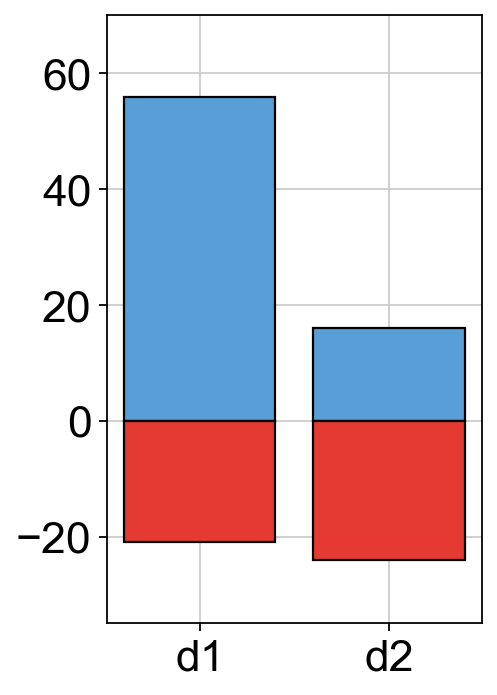

In [109]:
plt.figure(figsize=(3,5))
ax21 = plt.subplot(111)
ax21.bar(['d1','d2'],[len(d1_norm_up_ccis), len(d2_norm_up_ccis)], color='#599ed6', 
         edgecolor='black', linewidth=1)
ax21.bar(['d1','d2'],[-len(d1_rpl_up_ccis), -len(d2_rpl_up_ccis)], color='#e43a32', 
         edgecolor='black', linewidth=1)
_ = plt.ylim([-35,70])

In [112]:
all_diff_ccis = list(set(d1_norm_up_ccis+d2_norm_up_ccis+d1_rpl_up_ccis+d2_rpl_up_ccis))
len(all_diff_ccis)

77

## pathway analysis

In [113]:
cellchat_info_df = pd.read_csv('/home/yuqiaoni/decidua/10xVisium/file/2Cluster/cellchat/interaction_input_CellChatDB.combined.csv', sep='\t', index_col=0)
all_cellchat_ccis = cellchat_info_df.index.tolist()

In [114]:
tmp_cci_ls = []
tmp_pathway_ls = []
tmp_ligand_ls = []
tmp_receptor_ls = []

for raw_cci in all_diff_ccis:
    cci_r = raw_cci.split('|')[1]+'_'+raw_cci.split('|')[0]
    cci = raw_cci.replace('|','_')
    if cci in all_cellchat_ccis:
        pathway = cellchat_info_df.loc[cci,'pathway_name']
        tmp_cci_ls.append(raw_cci)
        tmp_pathway_ls.append(pathway)
        tmp_ligand_ls.append(cellchat_info_df.loc[cci,'ligand'])
        tmp_receptor_ls.append(cellchat_info_df.loc[cci,'receptor'])
    elif cci_r in all_cellchat_ccis:
        pathway = cellchat_info_df.loc[cci_r,'pathway_name']
        tmp_cci_ls.append(raw_cci)
        tmp_pathway_ls.append(pathway)
        tmp_ligand_ls.append(cellchat_info_df.loc[cci_r,'ligand'])
        tmp_receptor_ls.append(cellchat_info_df.loc[cci_r,'receptor'])
    else:
        if re.match('COL', cci) and re.search('ITG', cci):
            pathway = 'COLLAGEN'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            tmp_ligand_ls.append(cci.split('_')[0])
            tmp_receptor_ls.append(cci.split('_')[1])
        elif re.search('LGALS', cci):
            pathway = 'GALECTIN'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            if re.match('LGALS', gene_a):
                tmp_ligand_ls.append(gene_a)
                tmp_receptor_ls.append(gene_b)
            else:
                tmp_ligand_ls.append(gene_b)
                tmp_receptor_ls.append(gene_a)
        elif re.search('FN1', cci):
            pathway = 'FN1'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('PTPRC', cci):
            pathway = 'CD45'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('THY1', cci):
            pathway = 'THY1'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('JAM', cci):
            pathway = 'JAM'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            if re.match('JAM', gene_a):
                tmp_ligand_ls.append(gene_a)
                tmp_receptor_ls.append(gene_b)
            else:
                tmp_ligand_ls.append(gene_b)
                tmp_receptor_ls.append(gene_a)
        elif re.search('HLA', cci) or re.search('KLR', cci):
            pathway = 'MHC-I'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            if re.match('HLA', gene_a):
                tmp_ligand_ls.append(gene_a)
                tmp_receptor_ls.append(gene_b)
            else:
                tmp_ligand_ls.append(gene_b)
                tmp_receptor_ls.append(gene_a)
        elif re.search('ICAM', cci):
            pathway = 'ICAM'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('LILRB', cci):
            pathway = 'MHC-I'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            if re.match('LILRB', gene_a):
                tmp_ligand_ls.append(gene_b)
                tmp_receptor_ls.append(gene_a)
            else:
                tmp_ligand_ls.append(gene_a)
                tmp_receptor_ls.append(gene_b)
        elif re.search('CSPG4', cci):
            pathway = 'CSPG4'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('WNT', cci):
            pathway = 'WNT'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
        elif re.search('ITGA|ITGB', cci):
            pathway = 'COLLAGEN'
            tmp_cci_ls.append(raw_cci)
            tmp_pathway_ls.append(pathway)
            gene_a, gene_b = cci.split('_')
            tmp_ligand_ls.append(gene_a)
            tmp_receptor_ls.append(gene_b)
#             print(cci)
        else:
            print(cci)

CD47_TYROBP
ATP6AP2_REN
APOA1_TYROBP
RARA_ALDH1A1
DAGLB_CNR1
C5AR1_RPS19
HCST_MICA
GP1BB_VWF
TYROBP_CD44
RARA_ALDH1A2
ABCA1_APOA1


In [115]:
path_meta_df = pd.DataFrame({'pathway':tmp_pathway_ls, 'ligand':tmp_ligand_ls, 'receptor':tmp_receptor_ls}, index=tmp_cci_ls)
paths = path_meta_df['pathway'].unique().tolist()

In [116]:
items = [d1_norm_up_ccis, d2_norm_up_ccis, d1_rpl_up_ccis, d2_rpl_up_ccis]
prefixs = ['D1_Ctrl', 'D2_Ctrl', 'D1_RPL', 'D2_RPL']

In [117]:
path_count_df = pd.DataFrame(index=paths, columns=prefixs)

for item, prefix in zip(items, prefixs):
    path_count = path_meta_df.loc[list(set(item).intersection(set(path_meta_df.index))),'pathway'].value_counts()
    for path, count in zip(path_count.index, path_count.values):
        path_count_df.loc[path, prefix] = count
        
path_count_df = path_count_df.fillna(0).applymap(int)

In [118]:
order_paths = [
    'COLLAGEN','LAMININ','COMPLEMENT','VCAM','CD99','WNT',
    'GAS','IL2','GALECTIN','CD39','GRN','CSPG4','CD45','CSF',
    'THY1',
    'VEGF','CXCL','TGFb','EGF',
    'PRL','SEMA7','OSM','SEMA4','IL1','THBS']

<AxesSubplot:>

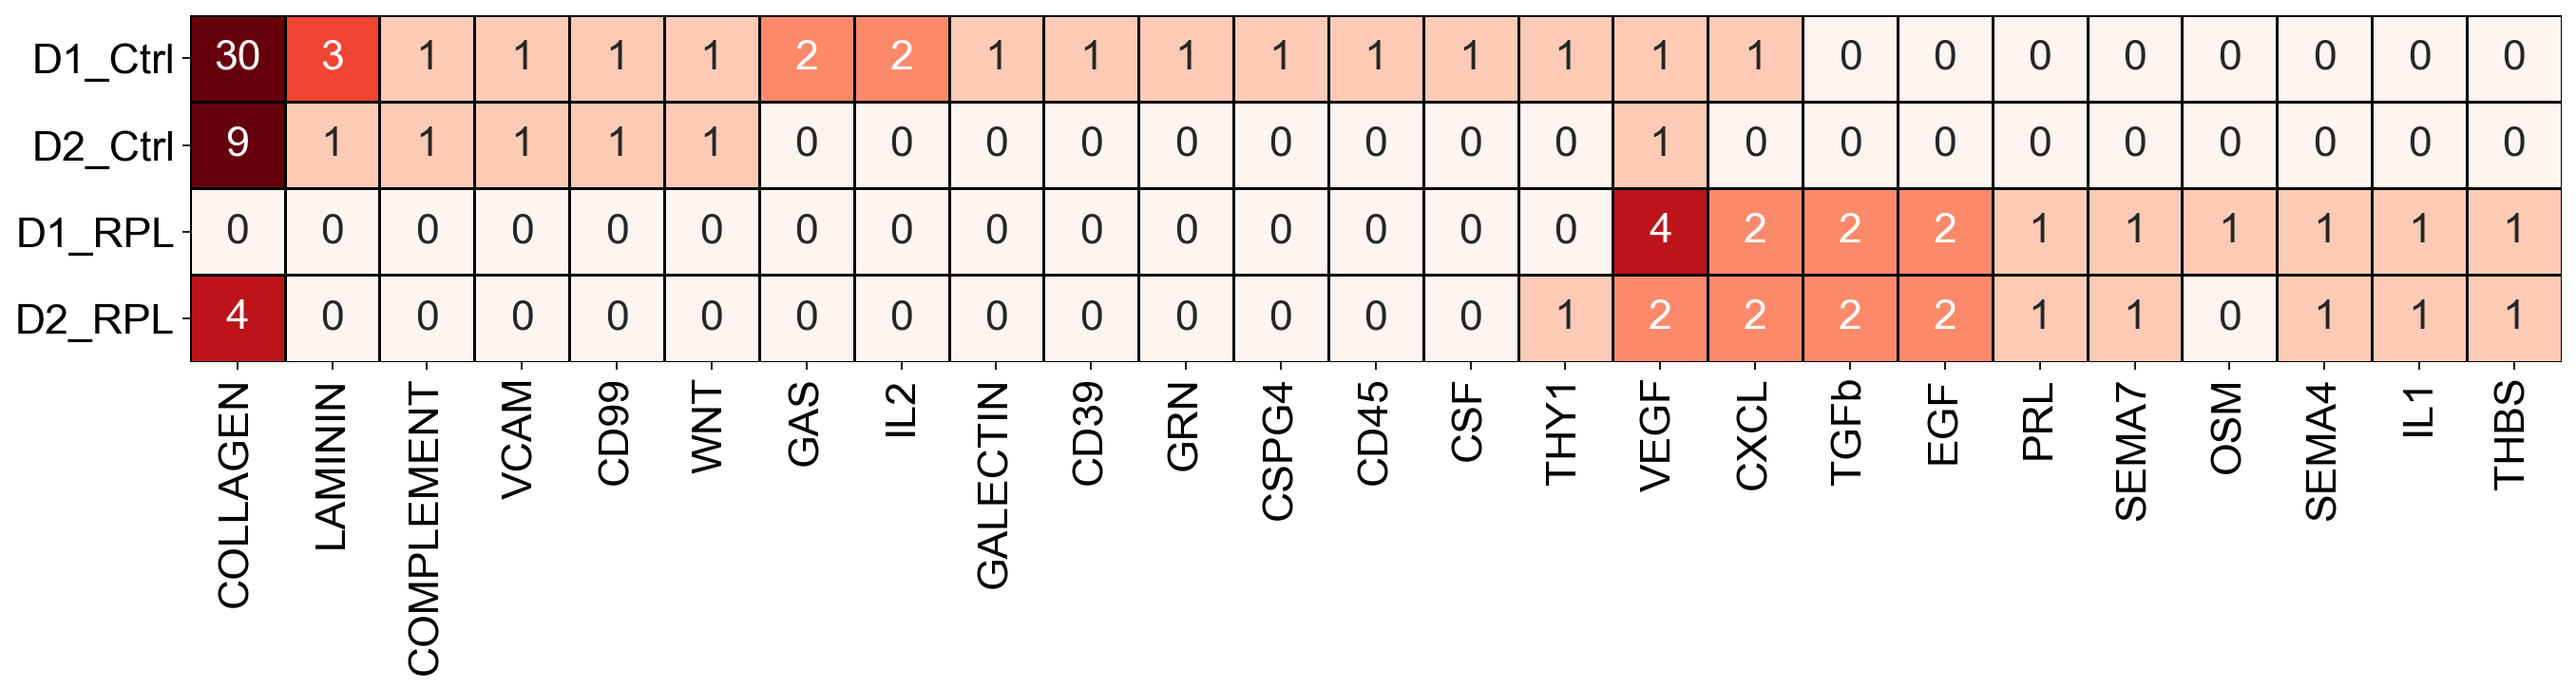

In [119]:
plt.figure(figsize=(20,3))
ax21 = plt.subplot(111)
sns.heatmap(path_count_df.loc[order_paths].T, cmap='Reds', vmax=5, linewidth=.5, linecolor='black', 
            annot=True, cbar=False)

In [135]:
diff_cci_df = pd.DataFrame(index=all_diff_ccis)
diff_cci_df['Is downregulated in RPL D1 (1:Yes)'] = diff_cci_df.index.map(lambda x: 1 if x in d1_norm_up_ccis else '')
diff_cci_df['Is downregulated in RPL D2 (1:Yes)'] = diff_cci_df.index.map(lambda x: 1 if x in d2_norm_up_ccis else '')
diff_cci_df['Is upregulated in RPL D1 (1:Yes)'] = diff_cci_df.index.map(lambda x: 1 if x in d1_rpl_up_ccis else '')
diff_cci_df['Is upregulated in RPL D2 (1:Yes)'] = diff_cci_df.index.map(lambda x: 1 if x in d2_rpl_up_ccis else '')

In [140]:
concat_anno_df = pd.concat([path_meta_df['pathway'].to_frame(), diff_cci_df], axis=1)
concat_anno_df.index = concat_anno_df.index.map(lambda x: x.replace('|','-'))

In [142]:
concat_anno_df.to_excel(indir+'/CCI_annotaton.xlsx')